In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=


In [2]:
%matplotlib notebook

In [3]:
import optax
import numpy as onp
import jax.numpy as jnp
import jax.random
import jax_md
from jax import jit, vmap, grad, lax
import matplotlib.pyplot as plt
import pickle
import mendeleev

In [4]:
import warnings
warnings.simplefilter('ignore')

In [5]:
import data
data_raw = data.get_gpaw_trajectories("./datasets/raw_ruslan_202104/new_datasets/defectDB/")

In [6]:
from collections import defaultdict

In [7]:
def compute_species_params(charge):
  element = mendeleev.element(charge)
  return [charge, element.atomic_volume, element.group_id, element.period]

In [9]:
data_processed = {}
for key, defect_vars in data_raw.items():
  energies = []
  coordinates = []
  forces = []
  data_processed[key] = []
  for traj in defect_vars:
    data_processed[key].append((traj[0], traj[-1]))

In [11]:
with open("gnn-traj.pkl", "rb") as params_file:
  params = pickle.load(params_file)

In [27]:
def relax_structure(atoms):
  lattice = atoms.cell.array.astype(onp.float32)
  displacement, shift = jax_md.space.periodic_general(lattice.T, fractional_coordinates=False)
  species_params = jnp.array([compute_species_params(int(charge)) for charge in atoms.get_atomic_numbers()],
                             dtype=jnp.float32)
  neighbor_fn, init_fn_gnn, energy_fn_gnn = jax_md.energy.graph_network_neighbor_list(
    displacement_fn=displacement,
    nodes=species_params,
    box_size=21,
    r_cutoff=4.9,
    dr_threshold=0.2)
  positions_jax = jnp.array(atoms.positions, dtype=jnp.float32)
  neighbor = neighbor_fn(positions_jax, extra_capacity=3)
  
  @jit
  def energy_fn(R):
    _neighbor = neighbor_fn(R, neighbor)
    return energy_fn_gnn(params, R, _neighbor)
  
  fire_init, fire_apply = jax_md.minimize.fire_descent(energy_fn, shift)
  final_state, e_traj = lax.scan(lambda s, _: (fire_apply(s), (energy_fn(s.position))),
                        fire_init(positions_jax),
                        jnp.arange(1000))
  return final_state.position, e_traj

In [28]:
rel0, etraj = relax_structure(data_processed['id23'][10][0])

<IPython.core.display.Javascript object>


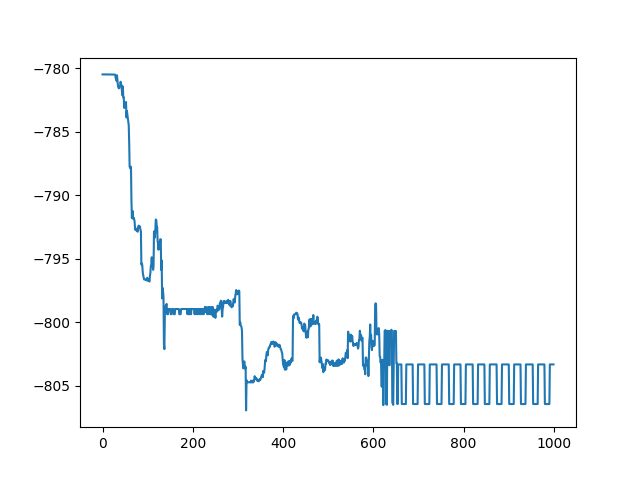

In [29]:
fig, ax = plt.subplots()
ax.plot(onp.arange(len(etraj)), etraj)

<IPython.core.display.Javascript object>


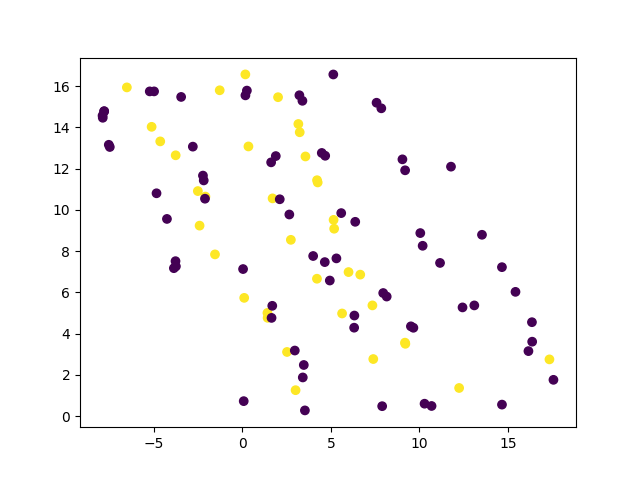

In [30]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(rel0[:, 0], rel0[:, 1],c=data_processed['id23'][10][0].get_atomic_numbers());

<IPython.core.display.Javascript object>


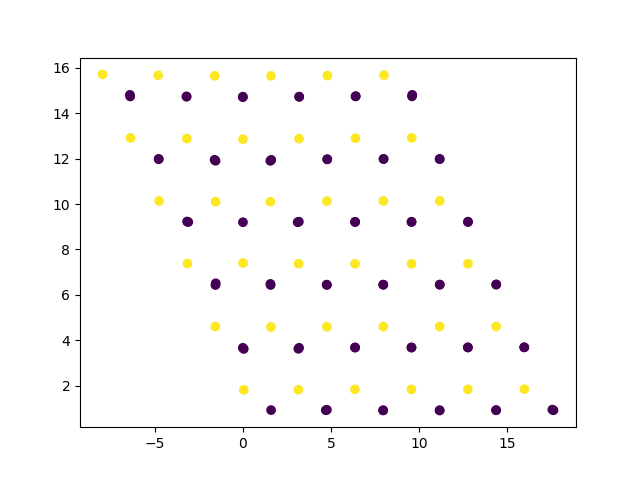

In [31]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(data_processed['id23'][10][1].positions[:, 0],
           data_processed['id23'][10][1].positions[:, 1],
           c=data_processed['id23'][10][0].get_atomic_numbers());